In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [9]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Bounding box classifier

**27.08.2020**

Find the bounding box ("bbox") which best captures the events within it.  
The bbox is limited in $x$ by the distance threshold (fixed) and some factor ($\geq 1$) of the time threshold.

In [10]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [11]:
from synthetic_data.plotting import plot_trajectory, add_plot_trajectory, add_plot_seg_boxes, add_plot_cluster_boxplots

In [12]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays

## Example 1

In [13]:
from synthetic_data.trajectory_class import get_pickle_trajectory
from stay_classification.metric_box_classifier.metric_box_classifier import stay_classifier_testing

time_thresh = 1/6
dist_thresh=0.25

In [14]:
data_dir = f"../../testdata/testdata_training_set__canonical_3stays/"
stays_tag = 3

In [19]:
!ls ../../classifiers_playground/metric_box_classifier/testdata_training_set__canonical_3stays/trajectory6_3stays.pkl

../../classifiers_playground/metric_box_classifier/testdata_training_set__canonical_3stays/trajectory6_3stays.pkl


### Classification

Load data

In [16]:
trajectory_nr = 445 #488 #958 #445

trajectory_tag = f"trajectory{trajectory_nr}_{stays_tag}stays"    
path_to_file =  data_dir + trajectory_tag

In [20]:
path_to_file = '../../classifiers_playground/metric_box_classifier/testdata_training_set__canonical_3stays/trajectory6_3stays'

In [21]:
t_arr, r_arr, x_arr, segments = get_pickle_trajectory(path_to_file)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, t_arr))

Plotting

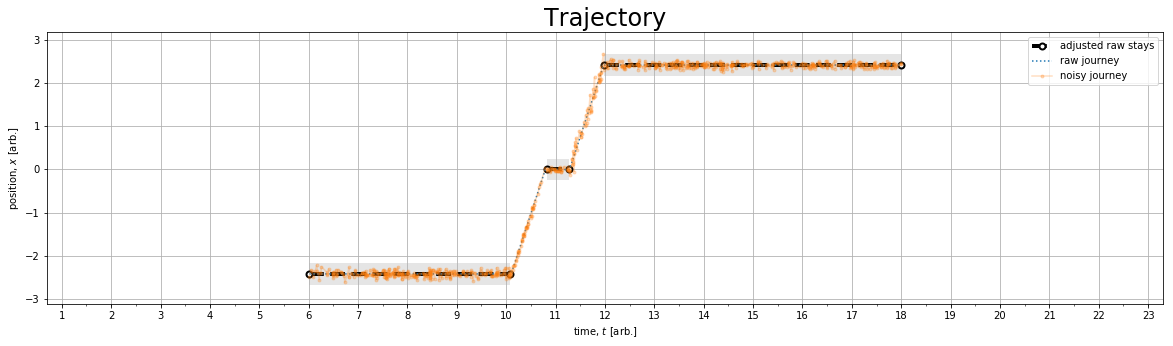

In [22]:
fig, ax = plt.subplots(1,1,figsize=[20,5])

ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]

add_plot_trajectory(t_arr, r_arr, x_arr, t_segs, x_segs, dist_thresh, ax)
ax.set_xlim(0.7,23.3)
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
#add_plot_cluster_boxplots(t_arr, x_arr, all_clusters[-1], dist_thresh, ax)
ax.set_ylim(ylim);
#ax.set_title(f"{stage_titels[-1]}", fontsize=16);

### Bounding box functions

In [23]:
def bbox(t_arr, x_arr):
    #a = np.where(img != 0)
    #bbox = t_arr.min(), t_arr.max(), x_arr.min(), x_arr.max()
    return np.array([t_arr.min(), t_arr.max(), x_arr.min(), x_arr.max()])

In [24]:
def bbox_splitx(t_arr, x_arr, split_x):
    mask_up = np.where(x_arr > split_x)
    mask_dn = np.where(x_arr < split_x)
    #a = np.where(img != 0)
    bbox_up = bbox(t_arr[mask_up], x_arr[mask_up])
    bbox_dn = bbox(t_arr[mask_dn], x_arr[mask_dn])
    return bbox_up, bbox_dn

In [25]:
def bbox_mask(t_arr, x_arr, bbox):
    mask = np.where(
        (t_arr > bbox[0]) & \
        (t_arr < bbox[1]) & \
        (x_arr > bbox[2]) & \
        (x_arr < bbox[3]))
    return mask

In [26]:
def bbox_mask_x(t_arr, x_arr, bbox):
    mask = np.where(
        (x_arr > bbox[2]) & \
        (x_arr < bbox[3]))
    return mask

In [27]:
def plot_box(bbox, ax=None):
    
    plot_dict = {"linestyle":'--',
                 "dashes":[4,2,],
                "color":"grey", 
                "linewidth":2}
    ms = [0,0,1,1,0]
    ns = [2,3,3,2,2]
    
    ts,xs = [],[]
    
    for i in range(5):        
        ts.append(bbox[ms[i]])
        xs.append(bbox[ns[i]])
    
    if ax == None:
        ax = plt.plot(ts,xs, **plot_dict)
        return ax
    else:
        ax.plot(ts,xs, **plot_dict)
        return None

Make the bbox and split it by half

In [28]:
bbox_ = bbox(t_arr, x_arr)

In [29]:
bbox_up, bbox_dn = bbox_splitx(t_arr, x_arr, np.mean(bbox_[2:]))

In [30]:
mask = bbox_mask(t_arr, x_arr, bbox_up)

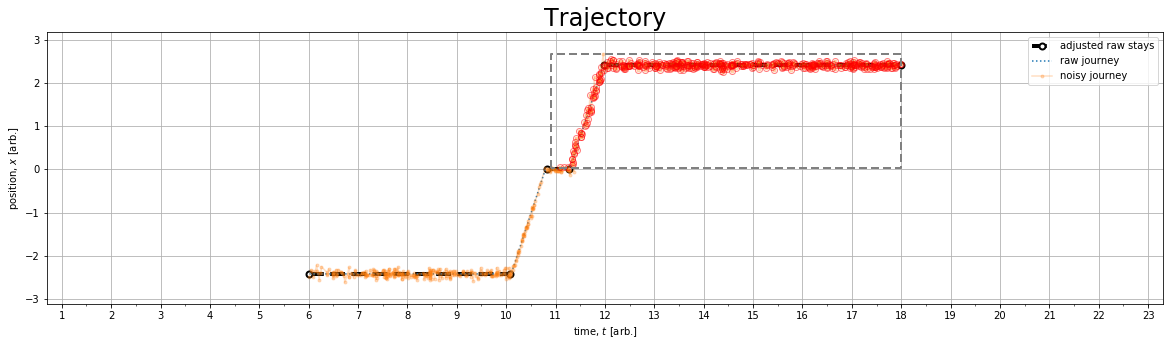

In [31]:
fig, ax = plt.subplots(1,1,figsize=[20,5])

ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]

add_plot_trajectory(t_arr, r_arr, x_arr, t_segs, x_segs, dist_thresh, ax)
ax.set_xlim(0.7,23.3)
#add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
ax.plot(t_arr[mask], x_arr[mask], 'ro', markerfacecolor="None", alpha=0.5)
plot_box(bbox_up, ax)
ax.set_ylim(ylim);

Shift the bbox

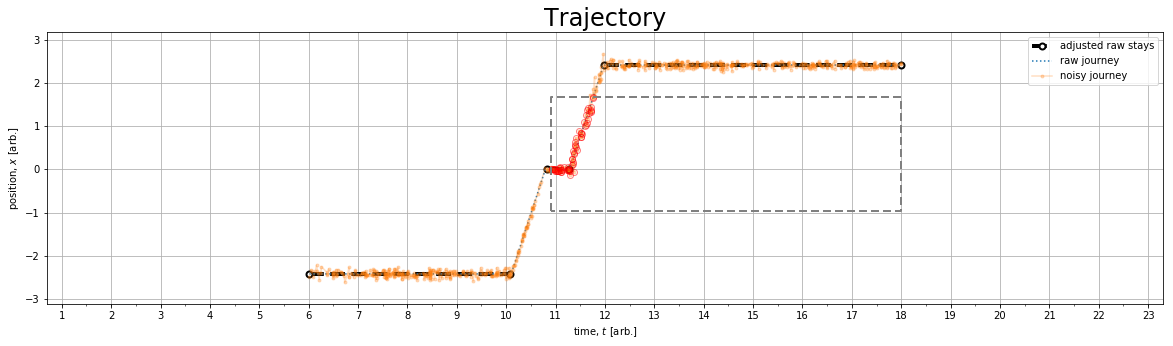

In [32]:
bbox_ = bbox_up+np.array([0,0,-1,-1])
mask = bbox_mask(t_arr, x_arr, bbox_)

fig, ax = plt.subplots(1,1,figsize=[20,5])

ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]

add_plot_trajectory(t_arr, r_arr, x_arr, t_segs, x_segs, dist_thresh, ax)
ax.set_xlim(0.7,23.3)
#add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
ax.plot(t_arr[mask], x_arr[mask], 'ro', markerfacecolor="None", alpha=0.5)

plot_box(bbox_, ax)
#add_plot_cluster_boxplots(t_arr, x_arr, all_clusters[-1], dist_thresh, ax)
ax.set_ylim(ylim);

Get the $x$-minimal bbox (using the distance threshold)

In [33]:
bbox_ = np.array([t_arr.min(),
                  t_arr.max(), 
                  np.mean([x_arr.min(),x_arr.max()])-dist_thresh, 
                  np.mean([x_arr.min(),x_arr.max()])+dist_thresh])

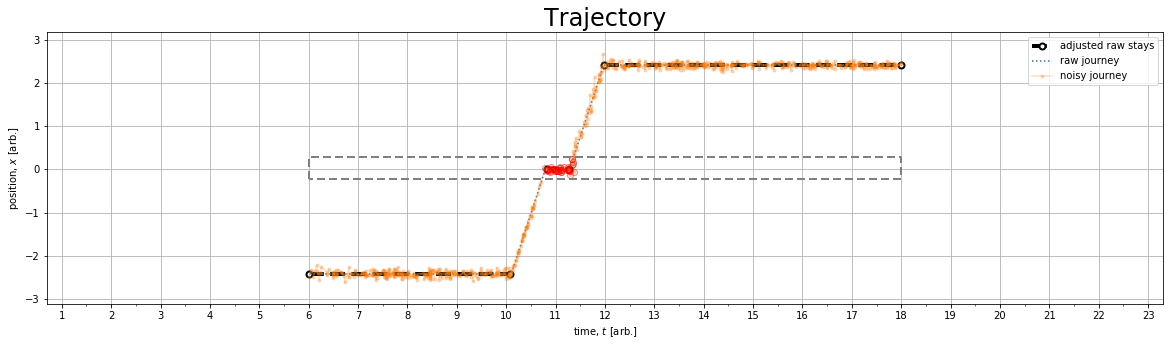

In [34]:
mask = bbox_mask_x(t_arr, x_arr, bbox_)

fig, ax = plt.subplots(1,1,figsize=[20,5])

ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]

add_plot_trajectory(t_arr, r_arr, x_arr, t_segs, x_segs, dist_thresh, ax)
ax.set_xlim(0.7,23.3)
#add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
ax.plot(t_arr[mask], x_arr[mask], 'ro', markerfacecolor="None", alpha=0.5)

plot_box(bbox_, ax)
#add_plot_cluster_boxplots(t_arr, x_arr, all_clusters[-1], dist_thresh, ax)
ax.set_ylim(ylim);

Find the optimal location(s) for the bbox

In [35]:
means,sizes = [],[]
dist_range=np.arange(x_arr.min()-dist_thresh,x_arr.max()+dist_thresh,dist_thresh/2)

for x in dist_range:
    mask = bbox_mask(t_arr, x_arr, bbox_+np.array([0,0,x,x]))
    means.append(np.mean(x_arr[mask]))
    sizes.append(np.size(x_arr[mask]))
    
means = np.array(means)
sizes = np.array(sizes)

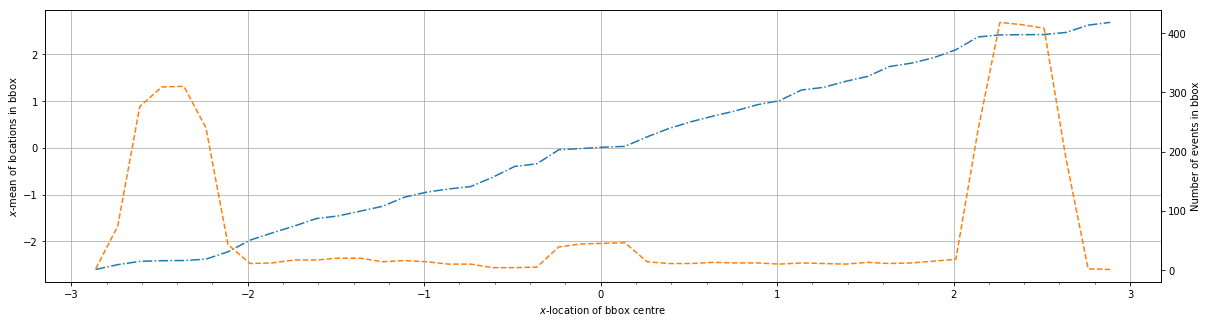

In [36]:
fig, ax = plt.subplots(1,1,figsize=[20,5])

ax.plot(dist_range, means, 'C0-.')
axt = ax.twinx()
axt.plot(dist_range, sizes, 'C1--')
ax.set_ylabel(r'$x$-mean of locations in bbox')
axt.set_ylabel('Number of events in bbox')
ax.set_xlabel(r'$x$-location of bbox centre')

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.2))

ax.grid()

For the first location, get a new bbox

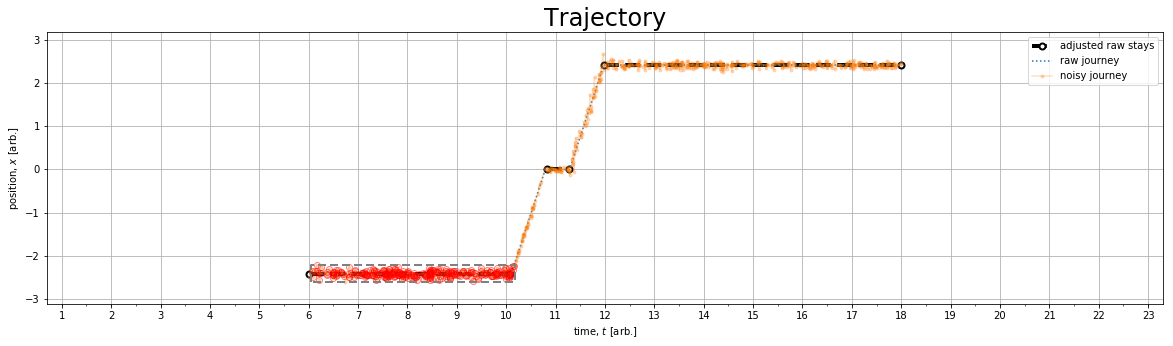

In [37]:
location = -2.4
#Get the bbox of one of the locations
bbox_ = np.array([t_arr.min(),
                  t_arr.max(), 
                  location-dist_thresh, 
                  location+dist_thresh])
# Get the mask of the bbox (_ie_ those events within the x-bounds)
mask = bbox_mask(t_arr, x_arr, bbox_)
offset = mask[0][0] #the first index

bbox_ = bbox(t_arr[mask], x_arr[mask])
mask = bbox_mask(t_arr, x_arr, bbox_)

fig, ax = plt.subplots(1,1,figsize=[20,5])

ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]

add_plot_trajectory(t_arr, r_arr, x_arr, t_segs, x_segs, dist_thresh, ax)
ax.set_xlim(0.7,23.3)
#add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
ax.plot(t_arr[mask], x_arr[mask], 'ro', markerfacecolor="None", alpha=0.5)

plot_box(bbox_, ax)
#add_plot_cluster_boxplots(t_arr, x_arr, all_clusters[-1], dist_thresh, ax)
ax.set_ylim(ylim);

Fors the second location, get a new bbox

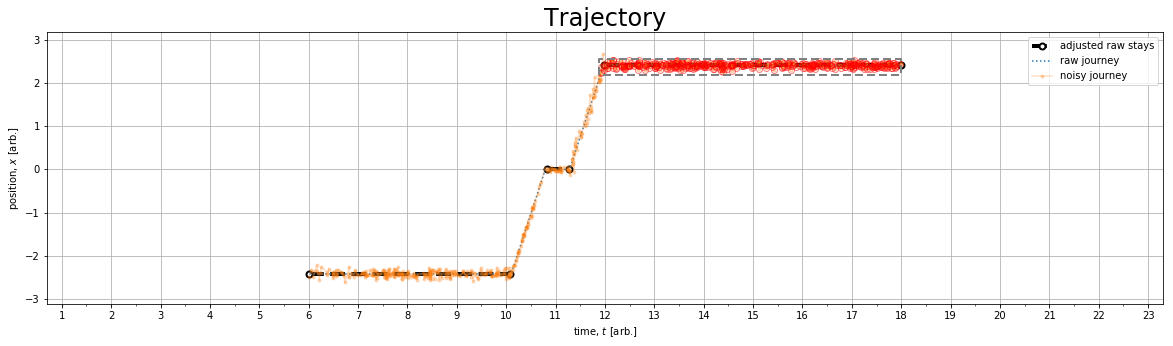

In [41]:
location = 2.4
#Get the bbox of one of the locations
bbox_ = np.array([t_arr.min(),
                  t_arr.max(), 
                  location-dist_thresh, 
                  location+dist_thresh])
# Get the mask of the bbox (_ie_ those events within the x-bounds)
mask = bbox_mask(t_arr, x_arr, bbox_)
offset = mask[0][0] #the first index

bbox_ = bbox(t_arr[mask], x_arr[mask])
mask = bbox_mask(t_arr, x_arr, bbox_)

fig, ax = plt.subplots(1,1,figsize=[20,5])

ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]

add_plot_trajectory(t_arr, r_arr, x_arr, t_segs, x_segs, dist_thresh, ax)
ax.set_xlim(0.7,23.3)
#add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
ax.plot(t_arr[mask], x_arr[mask], 'ro', markerfacecolor="None", alpha=0.5)

plot_box(bbox_, ax)
#add_plot_cluster_boxplots(t_arr, x_arr, all_clusters[-1], dist_thresh, ax)
ax.set_ylim(ylim);

In [42]:
means,sizes = [],[]
bbox_length = t_arr[mask].max()-t_arr[mask].min()

time_range=np.arange(t_arr[mask].min()-1.5*bbox_length,
                     t_arr[mask].max()+1.5*bbox_length,
                     time_thresh/2)

for x in time_range:
    mask = bbox_mask(t_arr, x_arr, bbox_+np.array([x,x,0,0]))
    means.append(np.mean(x_arr[mask]))
    sizes.append(np.size(x_arr[mask]))
    
means = np.array(means)
sizes = np.array(sizes)

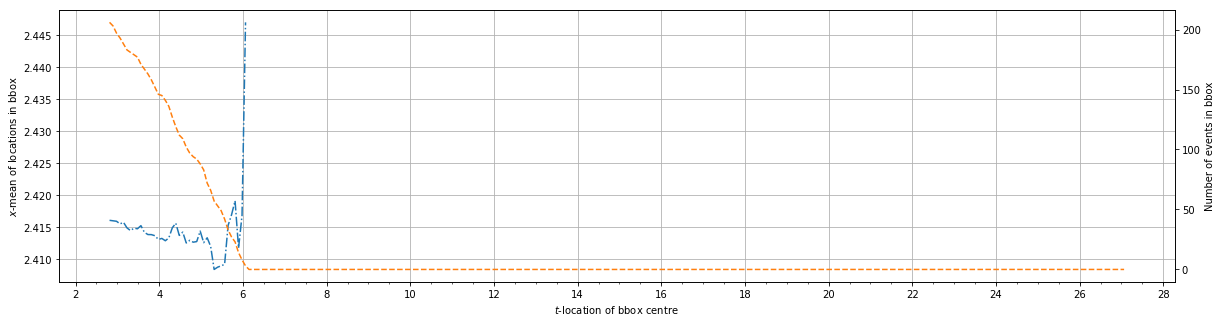

In [43]:
fig, ax = plt.subplots(1,1,figsize=[20,5])

ax.plot(time_range, means, 'C0-.')
axt = ax.twinx()
axt.plot(time_range, sizes, 'C1--')
ax.set_ylabel(r'$x$-mean of locations in bbox')
axt.set_ylabel('Number of events in bbox')
ax.set_xlabel(r'$t$-location of bbox centre')

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

ax.grid()

In [48]:
t_location_offset = 3

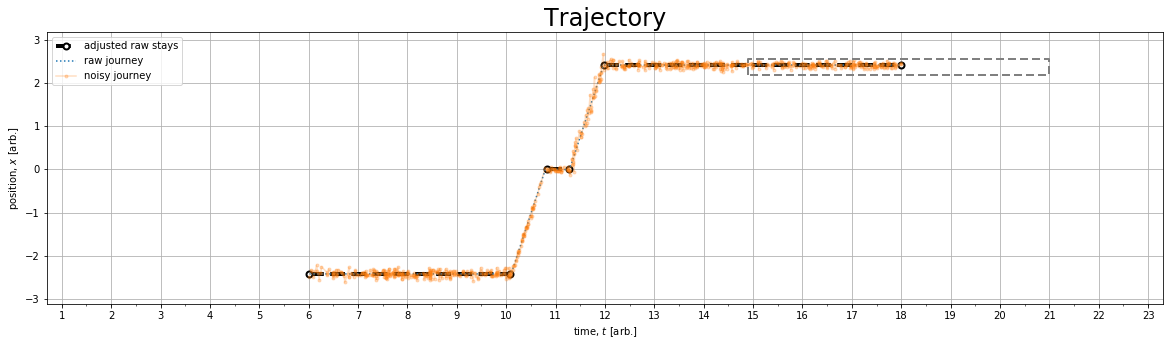

In [49]:
fig, ax = plt.subplots(1,1,figsize=[20,5])

ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]

add_plot_trajectory(t_arr, r_arr, x_arr, t_segs, x_segs, dist_thresh, ax)
ax.set_xlim(0.7,23.3)
#add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
ax.plot(t_arr[mask], x_arr[mask], 'ro', markerfacecolor="None", alpha=0.5)

plot_box(bbox_+np.array([t_location_offset,t_location_offset,0,0]), ax)
ax.set_ylim(ylim);

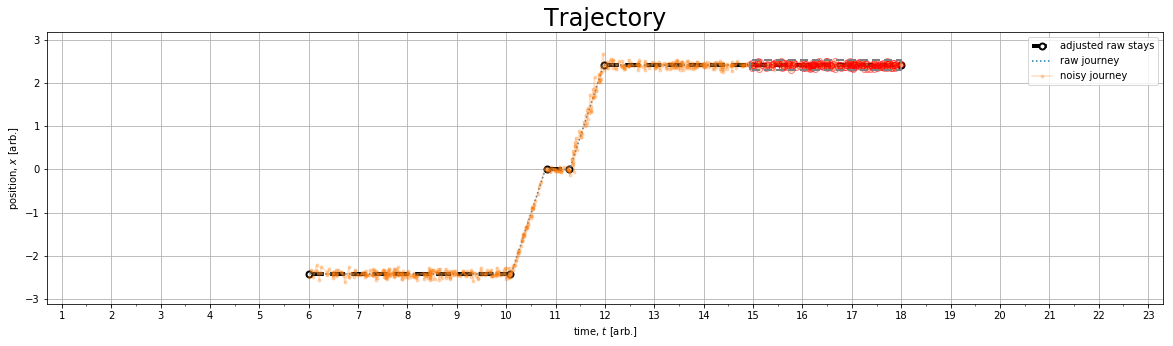

In [50]:
# Get the mask of the bbox (_ie_ those events within the x-bounds)
mask = bbox_mask(t_arr, x_arr, bbox_+np.array([t_location_offset,t_location_offset,0,0]))
offset = mask[0][0] #the first index

bbox_ = bbox(t_arr[mask], x_arr[mask])
mask = bbox_mask(t_arr, x_arr, bbox_)

fig, ax = plt.subplots(1,1,figsize=[20,5])

ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]

add_plot_trajectory(t_arr, r_arr, x_arr, t_segs, x_segs, dist_thresh, ax)
ax.set_xlim(0.7,23.3)
#add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
ax.plot(t_arr[mask], x_arr[mask], 'ro', markerfacecolor="None", alpha=0.5)

plot_box(bbox_, ax)
#add_plot_cluster_boxplots(t_arr, x_arr, all_clusters[-1], dist_thresh, ax)
ax.set_ylim(ylim);